In [1]:
import powerlaw
import numpy as np
import networkx as nx
# from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from graph_helpers import print_all_degree_stats, html_all_degree_stats, \
    compute_centrality_faction, compute_centrality_gender, compute_centrality_status, \
    html_centralities

# Load Graphs
If you do not have these two graph files, run the `create_wow_graph.py` python script.

In [2]:
# Load graphs
G = nx.read_gexf('./store/G_wow.gexf')
Gcc = nx.read_gexf('./store/Gcc_wow.gexf')

# get the undirected version of the GCC
Gcc_u = Gcc.to_undirected().copy()

# get node and edge lists of Gcc
node_list = np.array(list(Gcc.nodes))
edge_list = np.array(list(Gcc.edges))

# print quick info
N = len(node_list)
print(f'\t\tG\tGcc')
print(f"# of nodes:\t{len(list(G.nodes))}\t{N}")
print(f"# of links:\t{len(list(G.edges))}\t{len(edge_list)}")

		G	Gcc
# of nodes:	264	261
# of links:	4010	4009


# Degree Distributions

In [3]:
# Get arrays of total, out- and in-degrees
tot_deg = np.array([v for _, v in Gcc.degree])
out_deg = np.array([v for _, v in Gcc.out_degree])
in_deg = np.array([v for _, v in Gcc.in_degree])

In [ ]:
# calculate probability of connection
p_out = out_deg.mean() / (N - 1)
p_in = in_deg.mean() / (N - 1)

# create random networks
G_rnd_out = nx.erdos_renyi_graph(n=N, p=p_out)
G_rnd_in = nx.erdos_renyi_graph(n=N, p=p_in)

# get degrees of random network
degs_rnd_out = np.array([v for _, v in G_rnd_out.degree()])
degs_rnd_in = np.array([v for _, v in G_rnd_in.degree()])

In [ ]:
# Plot in- and out-degree distributions
f, ax = plt.subplots(1, 2, figsize=(12, 5))
marker_str = '.-'
marker_size = 9
val, count = np.unique(in_deg, return_counts=True)
val_rnd, count_rnd = np.unique(degs_rnd_in, return_counts=True)
ax[0].plot(val[1:], count[1:], marker_str, markersize=marker_size, label="Network degree")
ax[0].plot(val_rnd, count_rnd, marker_str, markersize=marker_size, label="Random degree")
val, count = np.unique(out_deg, return_counts=True)
val_rnd, count_rnd = np.unique(degs_rnd_out, return_counts=True)
ax[1].plot(val[1:], count[1:], marker_str, markersize=marker_size, label="Network degree")
ax[1].plot(val_rnd, count_rnd, marker_str, markersize=marker_size, label="Random degree")

ax[0].set_title('Indegree Distribution of the Network')
ax[1].set_title('Outdegree Distribution of the Network')

ax[0].set_ylabel('Frequency')
ax[1].set_yticks([])
for i in range(2):
    ax[i].set_xlabel('Degree')
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
plt.tight_layout()
plt.savefig('./visualizations/degree_distributions.png', transparent=True)
plt.show()

In [ ]:
# in- vs. out-degree
plt.figure()
plt.title('In- vs. out-degree')
plt.scatter(out_deg, in_deg)
plt.xlabel('Outdegree')
plt.ylabel('Indegree')
plt.show()

In [ ]:
# display top characters in regards to total-, out- and in-degree
print('Top five characters according to')
print(f'Total degree:\t{", ".join(node_list[np.argsort(tot_deg)[::-1][:5]])}')
print(f'Out degree:\t{", ".join(node_list[np.argsort(out_deg)[::-1][:5]])}')
print(f'In degree:\t{", ".join(node_list[np.argsort(in_deg)[::-1][:5]])}')

# display bottom characters in regards to total-, out- and in-degree
print('\nBottom five characters according to')
print(f'Total degree:\t{", ".join(node_list[np.argsort(tot_deg)[:5]])}')
print(f'Out degree:\t{", ".join(node_list[np.argsort(out_deg)[:5]])}')
print(f'In degree:\t{", ".join(node_list[np.argsort(in_deg)[:5]])}')

# Network Stats

In [4]:
# generate a HTML table of network stats for each attribute defined
attr_dict = {
    'faction': ['Alliance', 'Horde'],
    'gender': ['Male', 'Female']
}

def get_nodes_from_attr(G, attr_name, attr):
    return [node[0] for node in G.nodes(data=True) if node[1][attr_name] == attr]

# print("Entire Network")
# print_all_degree_stats(Gcc)
for attr_name, attrs in attr_dict.items():
    for attr in attrs:
        # print(f"\nNetwork for {attr}")
        nodes_ = get_nodes_from_attr(Gcc, attr_name, attr)
        G_sub = Gcc.subgraph(nodes_)
        html_all_degree_stats(G_sub, './tables/degree_stats/' + attr_name + '_' + attr + '.txt')
        # print_all_degree_stats(G_sub)

In [5]:
for name, deg in [['In-degree', in_deg], ['Out-degree', out_deg], ['Total-degree', tot_deg]]:
    deg_vals = deg[deg > 0]
    exp = powerlaw.Fit(deg_vals, discrete=True, verbose=False).alpha
    print(f'{name} exponent: {exp}')

In-degree exponent: 3.017732528086118
Out-degree exponent: 4.734152833620512
Total-degree exponent: 3.7069314597931315


In [6]:
# compute Assortativity
ast_degree = nx.degree_assortativity_coefficient(Gcc_u)
ast_faction = nx.attribute_assortativity_coefficient(Gcc_u, 'faction')
ast_status = nx.attribute_assortativity_coefficient(Gcc_u, 'status')
ast_gender = nx.attribute_assortativity_coefficient(Gcc_u, 'gender')

# display
print("Assortativity of the undirected graph based on")
print(f'\tdegree:\t\t{ast_degree:.4f}')
print(f'\tfaction:\t{ast_faction:.4f}')
print(f'\tstatus:\t\t{ast_status:.4f}')
print(f'\tgender:\t\t{ast_gender:.4f}')

Assortativity of the undirected graph based on
	degree:		-0.0519
	faction:	0.1691
	status:		0.0451
	gender:		0.0585


In [7]:
# calculate average shortest path lengths
print('Average shortest path for')
print(f'\tDirected:\t{nx.average_shortest_path_length(Gcc):.4f}') 
print(f'\tUndirected:\t{nx.average_shortest_path_length(Gcc_u):.4f}')

Average shortest path for
	Directed:	2.4103
	Undirected:	2.2964


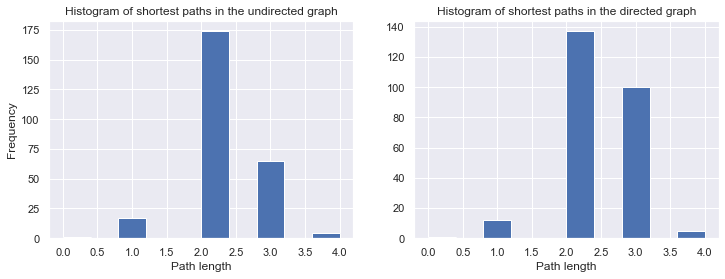

In [8]:
# compute the shortest path length distributrions of the directed and undirected networks
sp_lengths_gcc_u = [v for _, v in list(nx.all_pairs_shortest_path_length(Gcc_u))[0][1].items()]
sp_lengths_gcc = [v for _, v in list(nx.all_pairs_shortest_path_length(Gcc))[0][1].items()]

# plot histograms of the distributions
f, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(sp_lengths_gcc_u)
ax[0].set_title('Histogram of shortest paths in the undirected graph')
ax[1].hist(sp_lengths_gcc)
ax[1].set_title('Histogram of shortest paths in the directed graph')
for i in range(2):
    ax[i].set_xlabel('Path length')
ax[0].set_ylabel('Frequency')
plt.show()

In [21]:
# compute centrality measures for faction
columns = ['Horde', 'Alliance', 'Neutral']
row_data = []
print("\t")
for measure in ['deg', 'bwn', 'eig']:
    h, a, n = compute_centrality_faction(G, measure)
    row = f"{measure}\t{h:.6f}\t{a:.6f}\t{n:.6f}"
    row_data.append(row)
    print(row)
html_centralities('./tables/centrality/faction.txt', columns, row_data)

	
deg	0.134007	0.179356	0.096958
bwn	0.007062	0.008802	0.004222
eig	0.047472	0.067552	0.034995


In [22]:
# compute centrality measures for gender
columns = ['Male', 'Female']
row_data = []
for measure in ['deg', 'bwn', 'eig']:
    m, f = compute_centrality_gender(G, measure)
    row = f"{measure}\t{m:.6f}\t{f:.6f}"
    row_data.append(row)
    print(row)
html_centralities('./tables/centrality/gender.txt', columns, row_data)

deg	0.114426	0.119036
bwn	0.005290	0.005649
eig	0.042228	0.041210


In [23]:
# compute centrality measures for status
columns = ['Deceased', 'Alive']
row_data = []
for measure in ['deg', 'bwn', 'eig']:
    d, a = compute_centrality_status(G, measure)
    row = f"{measure}\t{d:.6f}\t{a:.6f}"
    row_data.append(row)
    print(row)
html_centralities('./tables/centrality/status.txt', columns, row_data)

deg	0.125125	0.102458
bwn	0.006439	0.003929
eig	0.044177	0.039021


# Attribute Distributions

In [ ]:
# get distribution of all attributes
attr_names = ['gender', 'faction', 'status', 'race']
f, ax = plt.subplots(len(attr_names), 1, figsize=(30, 30))
for i, aname in enumerate(attr_names):
    attr_list = np.array(list(nx.get_node_attributes(Gcc, aname).values()))
    attr_keys, attr_counts = np.unique(attr_list, return_counts=True)
    ax[i].set_title(f'{aname} distribution'.title(), fontsize=20)
    ax[i].bar(attr_keys, attr_counts)
    ax[i].set_ylabel('count', fontsize=14)

    if aname == 'race':
        xlabel_rotation = 90
    else:
        xlabel_rotation = 0
    plt.setp(ax[i].get_xticklabels(), fontsize=14, rotation=xlabel_rotation)
    plt.setp(ax[i].get_yticklabels(), fontsize=14)
plt.savefig('./visualizations/attribute_distributions.png', transparent=True)
plt.show()

# Network Visualization
On the undirected version of the network

In [ ]:
# get nodes and edges with data
node_data = Gcc_u.nodes(data=True)
edge_data = Gcc_u.edges(data=True)

# determine node size in regards to degree of node
node_sizes = [2*v for v in dict(Gcc_u.degree).values()]

# create node color list depending on faction
node_colors = []
for _, attr in list(node_data):
    fac = attr['faction']
    if fac == 'Horde':
        node_colors.append('#FF3333')
    elif fac == 'Alliance':
        node_colors.append('#3399FF')
    else:
        node_colors.append('#A0A0A0')

# create edge color list depending on faction of the two connecting nodes
edge_colors = []
for n1, n2, _ in list(edge_data):
    f1 = node_data[n1]['faction']
    f2 = node_data[n2]['faction']

    if f1 == 'Alliance':
        if f2 == 'Alliance':
            edge_colors.append('#3399FF')
        elif f2 == 'Horde':
            edge_colors.append('#005700')
        else:
            edge_colors.append('#A0A0A0')
    elif f1 == 'Horde':
        if f2 == 'Alliance':
            edge_colors.append('#005700')
        elif f2 == 'Horde':
            edge_colors.append('#FF3333')
        else:
            edge_colors.append('#A0A0A0')
    else:
        edge_colors.append('#A0A0A0')

In [ ]:
# Setup FA2 w. parameters
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,    # Dissuade hubs
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=True,
    gravity=1,

    # Log
    verbose=False
)

# compute node positions with the fa algorithm
node_pos = forceatlas2.forceatlas2_networkx_layout(Gcc_u, pos=None, iterations=2000)

In [ ]:
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(Gcc_u, node_pos, node_size=node_sizes, node_color=node_colors, alpha=0.75)
nx.draw_networkx_edges(Gcc_u, node_pos, edge_color=edge_colors, alpha=0.2)
plt.title('Warcraft Major Character Network')
plt.axis('off')
plt.savefig('./visualizations/network.png')
plt.savefig('./visualizations/network_trans.png', transparent=True)
plt.show()

# Backbone Analysis
Source: [Extracting the multiscale backbone of complex weighted networks](https://www.pnas.org/content/pnas/106/16/6483.full.pdf)